# Exploratory Data Analysis
This document contains some information on the exploratory data analysis done.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# load dataset
# load dataset
df1 = pd.read_csv("../data/raw/data2016-2025.csv", index_col='date')
df2 = pd.read_csv("../data/raw/data2006-2015.csv", index_col='date')
df3 = pd.read_csv("../data/raw/data1996-2005.csv", index_col='date')
df4 = pd.read_csv("../data/raw/data1986-1995.csv", index_col='date')
df5 = pd.read_csv("../data/raw/data1976-1985.csv", index_col='date')
df = pd.concat([df1,df2, df3, df4, df5]).drop_duplicates()
df = df.sort_index()
pd.set_option("display.max_rows", None)
isna = df.isna().mean()


## Preprocessing
We take some time to preprocess the data set. In particular, we search for missing values and truncate the time range of the time series to have a complete dataset that is as long as possible.

In [3]:
# show the correspondences between key codes and the item level descriptions
codes = pd.read_csv("../data/cu-item.tsv", sep="\t", index_col='item_code')

data = []
for col in df.columns:
    na_percent = df[col].isna().mean()
    data.append([col, na_percent, codes.loc[col[8:]].item_name])
dfnan = pd.DataFrame(data)
#dfnan

In [4]:
# Remove all time series variables that are missing more than 30% of the data
# we will later truncate the time
mask = dfnan[1]< .3
dfnan[mask]

,0,1,2
0,CUUR0000SEFA01,0.038591,Flour and prepared flour mixes
1,CUUR0000SEFA02,0.038591,Breakfast cereal
2,CUUR0000SEFA03,0.038591,"Rice, pasta, cornmeal"
5,CUUR0000SEFB03,0.040268,"Cakes, cupcakes, and cookies"
6,CUUR0000SEFB04,0.040268,Other bakery products
7,CUUR0000SEFC01,0.000000,Uncooked ground beef
12,CUUR0000SEFD02,0.040268,Ham
13,CUUR0000SEFD03,0.000000,Pork chops
20,CUUR0000SEFJ02,0.038591,Cheese and related products
21,CUUR0000SEFJ03,0.038591,Ice cream and related products


In [5]:
sublist = dfnan[mask][0].tolist()
description = dfnan[mask][2].tolist()
var_dict = dict(zip(sublist, description))
df_sub = df[sublist].copy()
df_sub.dropna(inplace=True)  # truncates time by removing rows
df = df_sub

## Visualization and EDA
Here we plot some variables, and correlation functions to make some quick inferences

In [49]:
from pandas.plotting import lag_plot

def my_grid_plot(df, option='acf', title='code', lag = 1):
    ncols = 3
    nrows = len(df.columns)//3 + 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10))
    axes = axes.flatten() # easier indexing
    i = 0
    for name in df.columns:
        data = df[name]
        if title == 'description':
            fig_name = var_dict[name]
        elif title == 'code':
            fig_name = name
        if option=='acf':
            plot_acf(data, ax = axes[i], title=fig_name)
        elif option == 'pacf':
            plot_pacf(data, ax = axes[i], title=fig_name)
        elif option == 'timeseries':
            #data = np.log(data)
            data.plot(figsize=(10,10), ax = axes[i], title=fig_name)
            plt.xlabel('Date')
            plt.ylabel('CPI')
        elif option == 'lag':
            lag_plot(data, lag = lag, ax=axes[i])
            axes[i].set_title(fig_name)
        i+=1
    if option == 'timeseries':
        fig.autofmt_xdate()
    plt.tight_layout(h_pad = 3)
    plt.show()

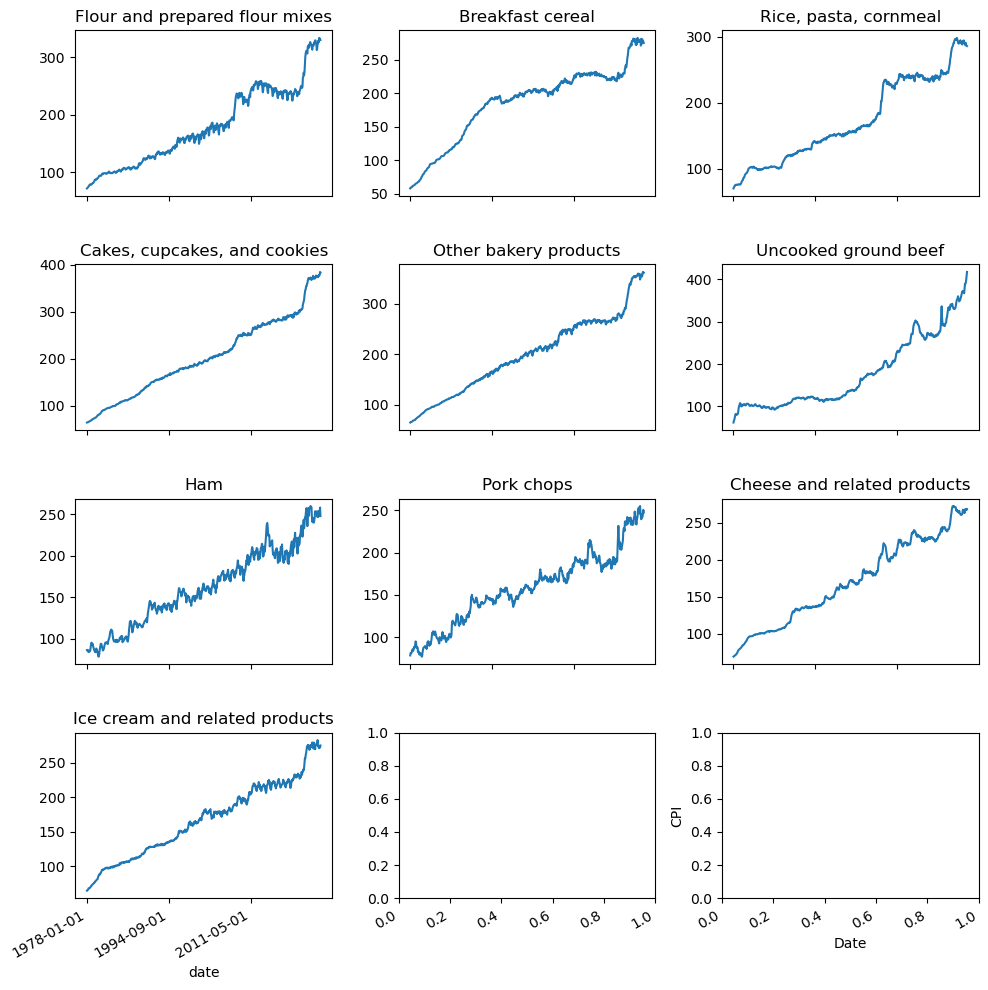

In [50]:
# time series plots
my_grid_plot(df, option="timeseries", title='description')


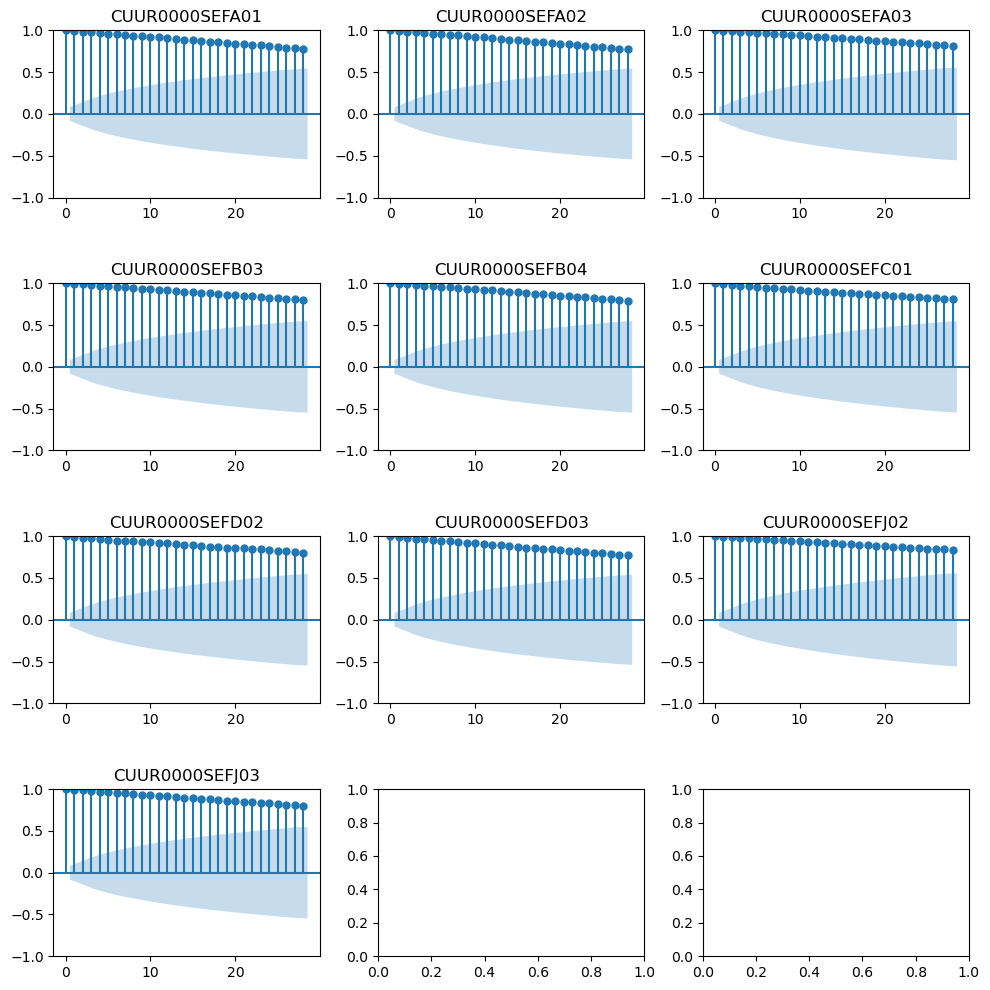

In [51]:
# plot of autocorrelation functions
my_grid_plot(df, "acf")

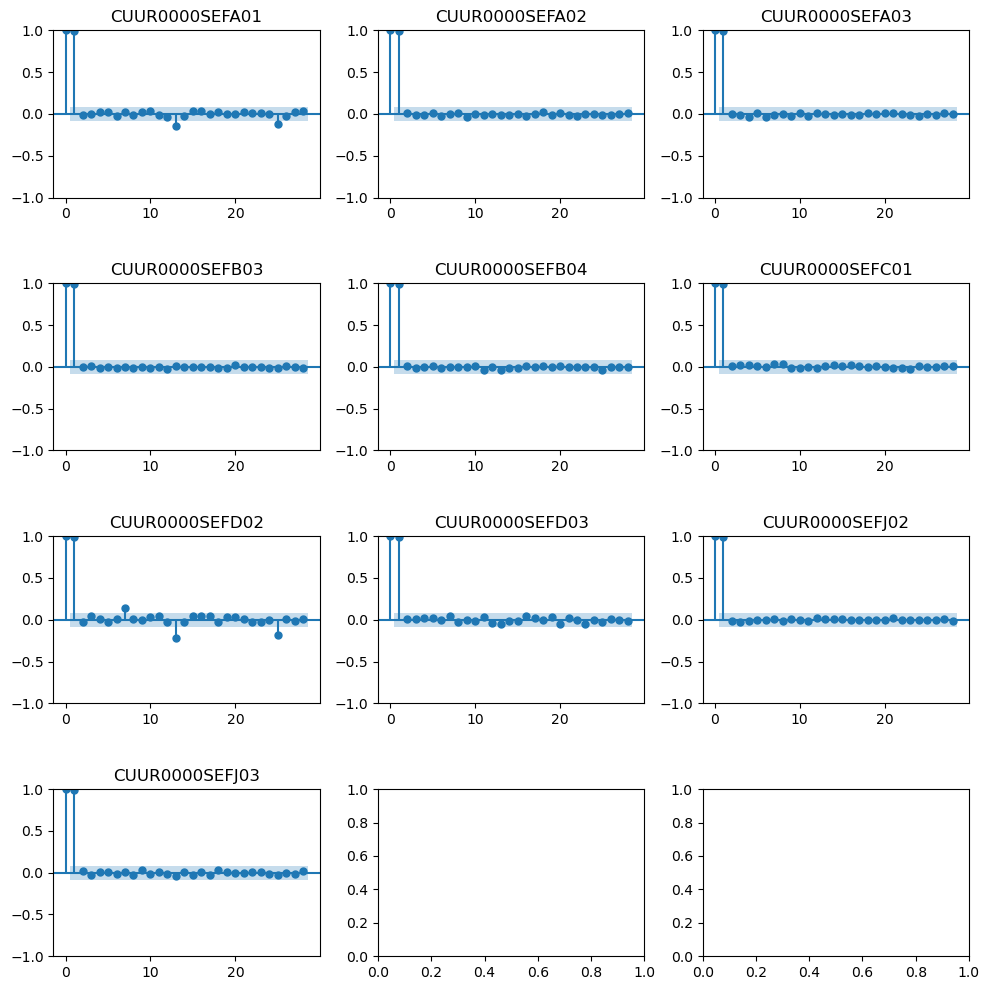

In [52]:
# partial autocorrelation function
my_grid_plot(df, option='pacf')

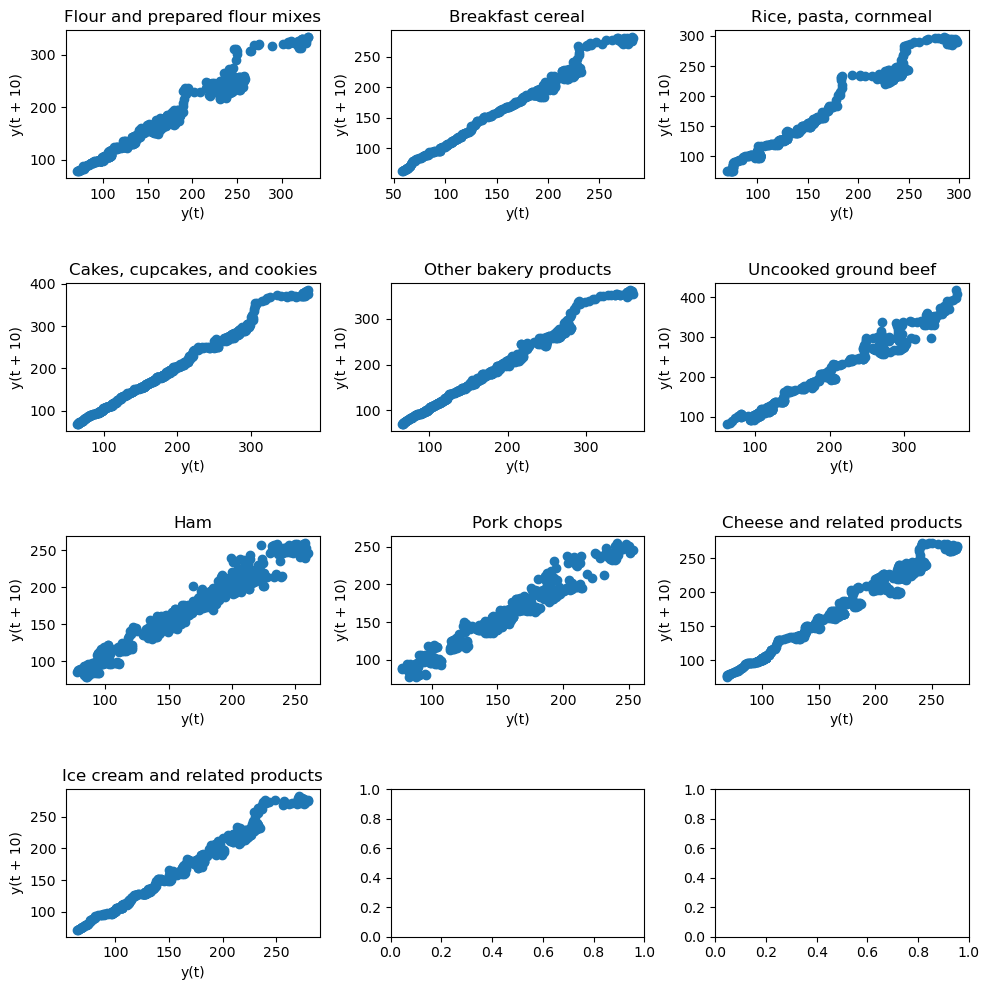

In [58]:
my_grid_plot(df, option='lag', title='description', lag=10)

Loss function should be informed by use of the model.
- baseline 
- consider big life events (e.g. pandemic)
- compare impact on dropping "big events"

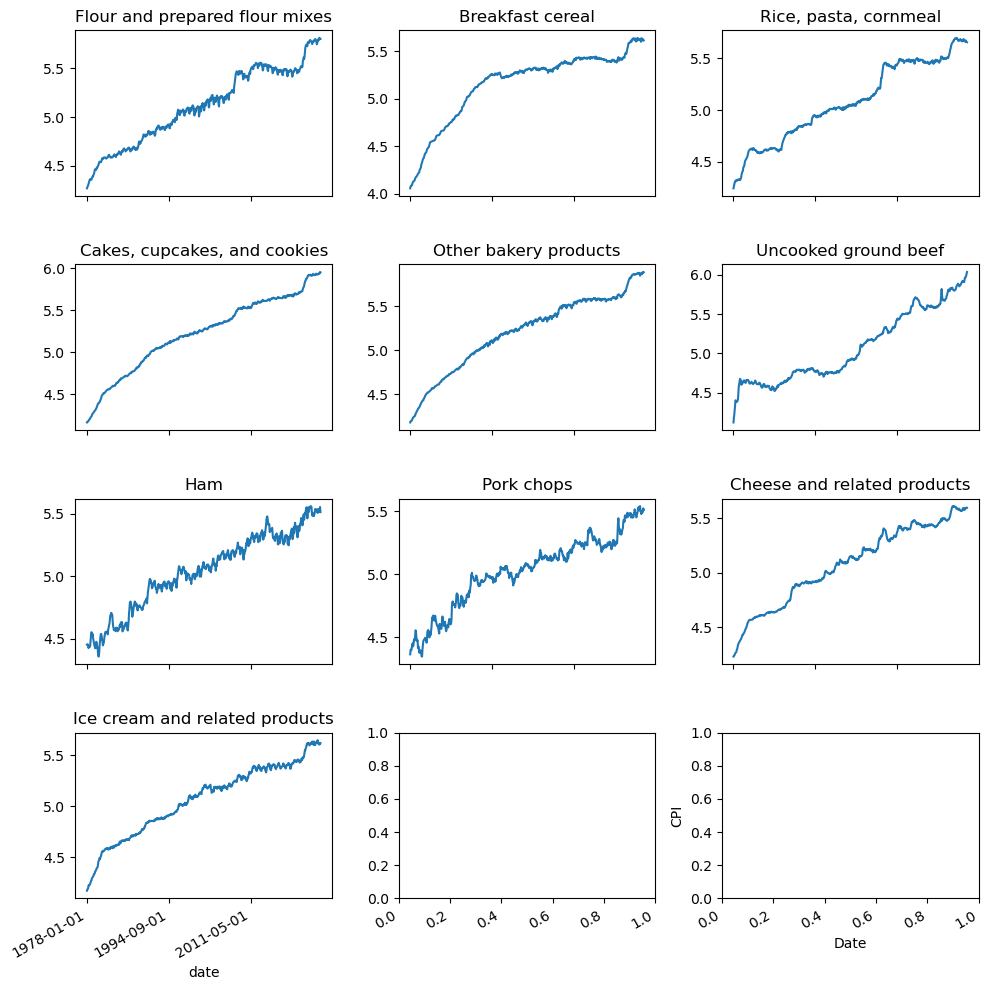

In [16]:
#my_grid_plot(df['CUUR000SEFJ01'], option="timeseries")

# VECM and Cointegration
It seems that differencing/lag variables will not help us get stationarity. Thus we move to VECM. First, we stastically test for the cointegration with the Johansen test.# Perform the Johansen Cointegration Test with a specified number of zero
specified_number = 0  # Testing for zero cointegrating relationships
coint_test_result = coint_johansen(data, specified_number, 1)

In [11]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen


In [12]:
# Perform the Johansen Cointegration Test with a specified number of zero
specified_number = 0  # Testing for zero cointegrating relationships
coint_test_result = coint_johansen(df_sub, specified_number, 1)

In [13]:
# Extract the trace statistics and eigen statistics
trace_stats = coint_test_result.lr1
eigen_stats = coint_test_result.lr2

# Print the test results
print("Johansen Cointegration Test Results (Testing for Zero Cointegrating Relationships):")
print(f"Trace Statistics: {coint_test_result.lr1}")
print(f"Critical Values: {coint_test_result.cvt}")

Johansen Cointegration Test Results (Testing for Zero Cointegrating Relationships):
Trace Statistics: [454.69014019 308.45361755 215.68166537 148.61425167  96.05191182
  61.2733392   39.12544995  20.83331776   6.94349637   2.12974593]
Critical Values: [[232.103  239.2468 253.2526]
 [190.8714 197.3772 210.0366]
 [153.6341 159.529  171.0905]
 [120.3673 125.6185 135.9825]
 [ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]
 [ 27.0669  29.7961  35.4628]
 [ 13.4294  15.4943  19.9349]
 [  2.7055   3.8415   6.6349]]


In [14]:
# Define stock pairs
stock_pairs = [('AAPL', 'AMZN'), ('MSFT', 'AAPL'), ('AMZN', 'MSFT')]

# Separate the output sections
print("\n" + "-" * 50 + "\n")

# Interpret the results for each pair
for i, (stock1, stock2) in enumerate(stock_pairs):
    trace_statistic = trace_stats[i]
    eigen_statistic = eigen_stats[i]
    print(f"Pair {i + 1} ({stock1} and {stock2}):")
    print(f"Trace Statistic: {trace_statistic}")
    print(f"Eigen Statistic: {eigen_statistic}")
    print("\n" + "-" * 50 + "\n")


--------------------------------------------------

Pair 1 (AAPL and AMZN):
Trace Statistic: 454.6901401923321
Eigen Statistic: 146.23652264114983

--------------------------------------------------

Pair 2 (MSFT and AAPL):
Trace Statistic: 308.4536175511823
Eigen Statistic: 92.77195218442475

--------------------------------------------------

Pair 3 (AMZN and MSFT):
Trace Statistic: 215.68166536675753
Eigen Statistic: 67.06741369222777

--------------------------------------------------

